In [1]:
# !gdown 1-71hYGVEWoJH3JTtH9CAsSQ6PotpiZBW

In [2]:
import os
import cv2
import shutil
import secrets
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import Sequential, Model
from keras import optimizers
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from PIL import ImageFile
import seaborn as sns
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# from tensorflow.keras.applications.alexnet import AlexNet, preprocess_input

In [3]:
PARENT_PATH = os.getcwd()
DATA_PATH = os.path.join(os.getcwd(),"CombinedNew", "Combined New")
TEST_PATH = os.path.join(DATA_PATH, "test")
TRAIN_PATH = os.path.join(DATA_PATH, "train")
NEW_TRAIN_PATH = os.path.join(DATA_PATH, "new_train")
VALID_PATH = os.path.join(DATA_PATH, "valid")
UNSEEN_PATH = os.path.join(DATA_PATH, "unseen")
MODEL_PATH = "drive/MyDrive/models"
NUM_CLASSES = 8

In [ ]:
if os.path.exists(DATA_PATH):
  shutil.rmtree(DATA_PATH)
from zipfile import ZipFile
password = "57Rk!F8yUz38"
with ZipFile('drive/MyDrive/CombinedNew.zip') as zipObj:
  zipObj.extractall()

In [5]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
NUM_EPOCH = 30

In [6]:
for class_folder in os.listdir(TRAIN_PATH):
  class_path = os.path.join(TRAIN_PATH, class_folder)
  if class_folder == ".DS_Store":
      continue
  train_imgs, test_imgs = train_test_split(os.listdir(class_path), test_size=0.2, random_state = 42)

  for img in train_imgs: 
    src = os.path.join(class_path, img)
    dst = os.path.join(NEW_TRAIN_PATH, class_folder, img)
    if not os.path.exists(os.path.join(NEW_TRAIN_PATH, class_folder)):
      os.makedirs(os.path.join(NEW_TRAIN_PATH, class_folder))
    shutil.copy(src, dst)

  for img in test_imgs: 
    src = os.path.join(class_path, img)
    dst = os.path.join(VALID_PATH, class_folder, img)
    if not os.path.exists(os.path.join(VALID_PATH, class_folder)):
      os.makedirs(os.path.join(VALID_PATH, class_folder))
    shutil.copy(src, dst)

In [17]:
def create_df(DATA_PATH):
  cls_names = os.listdir(DATA_PATH)
  data = []
  for cls in cls_names: 
    if cls == ".DS_Store":
      continue
    cls_path = os.path.join(DATA_PATH, cls)
    print(cls_path)
    for file in os.listdir(cls_path):
      data.append({"Filename": os.path.join(cls, file), "Class": cls})
  df = pd.DataFrame(data)
  return df
  
train_df = create_df(NEW_TRAIN_PATH)
valid_df = create_df(VALID_PATH)
test_df = create_df(TEST_PATH)
unseen_df = create_df(UNSEEN_PATH)

/content/CombinedNew/Combined New/new_train/c6
/content/CombinedNew/Combined New/new_train/c2
/content/CombinedNew/Combined New/new_train/c5
/content/CombinedNew/Combined New/new_train/c3
/content/CombinedNew/Combined New/new_train/c1
/content/CombinedNew/Combined New/new_train/c7
/content/CombinedNew/Combined New/new_train/c0
/content/CombinedNew/Combined New/new_train/c4
/content/CombinedNew/Combined New/valid/c6
/content/CombinedNew/Combined New/valid/c2
/content/CombinedNew/Combined New/valid/c5
/content/CombinedNew/Combined New/valid/c3
/content/CombinedNew/Combined New/valid/c1
/content/CombinedNew/Combined New/valid/c7
/content/CombinedNew/Combined New/valid/c0
/content/CombinedNew/Combined New/valid/c4
/content/CombinedNew/Combined New/test/c6
/content/CombinedNew/Combined New/test/c2
/content/CombinedNew/Combined New/test/c5
/content/CombinedNew/Combined New/test/c3
/content/CombinedNew/Combined New/test/c1
/content/CombinedNew/Combined New/test/c7
/content/CombinedNew/Combine

<Axes: >

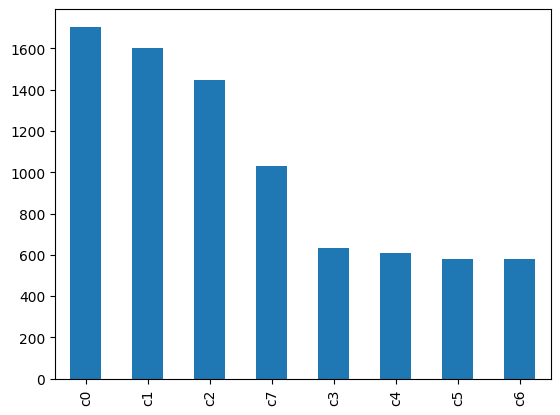

In [19]:
train_df['Class'].value_counts().plot.bar()

<Axes: >

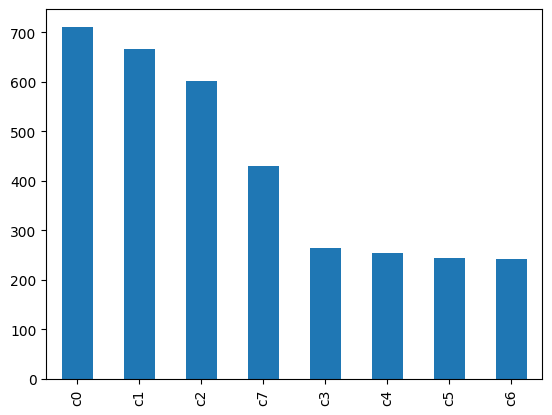

In [ ]:
test_df['Class'].value_counts().plot.bar()

In [9]:
rotation_range = 5
width_shift_range = 0.01
height_shift_range = 0.01
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
verticle_flip = False
fill_mode = "nearest"

In [60]:
train_datagen = ImageDataGenerator(
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range,
        zoom_range = zoom_range,
        fill_mode = fill_mode,
        validation_split = 0.2,
        preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(
        validation_split = 0.2,
        preprocessing_function = preprocess_input
)

train_data = train_datagen.flow_from_directory(NEW_TRAIN_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)

valid_data = test_datagen.flow_from_directory(VALID_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)
test_data = test_datagen.flow_from_directory(TEST_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)
unseen_data = test_datagen.flow_from_directory(UNSEEN_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)

Found 8176 images belonging to 8 classes.
Found 2049 images belonging to 8 classes.
Found 3414 images belonging to 8 classes.
Found 839 images belonging to 8 classes.


In [11]:
classes = [i for i in range(8)]
print(classes)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_data.classes)
class_weights = dict(enumerate(class_weights.flatten(), 0))
print(class_weights)

[0, 1, 2, 3, 4, 5, 6, 7]
{0: 0.5997652582159625, 1: 0.63875, 2: 0.7077562326869806, 3: 1.6170886075949367, 4: 1.6781609195402298, 5: 1.7620689655172415, 6: 1.768166089965398, 7: 0.9931972789115646}


In [12]:
base_model_inc = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

for layer in base_model_inc.layers:
    layer.trainable = True

87910968/87910968 [==============================] - 1s 0us/step


In [13]:
top_models_inc = Sequential()
top_models_inc.add(GlobalAveragePooling2D(input_shape=base_model_inc.output_shape[1:]))
top_models_inc.add(Dense(256, activation='relu', kernel_initializer='glorot_normal'))
top_models_inc.add(Dropout(0.5))
top_models_inc.add(Dense(8, activation='softmax', kernel_initializer='glorot_normal'))
top_models_inc = Model(inputs = base_model_inc.input, outputs = top_models_inc(base_model_inc.output))

top_models_inc.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0002, momentum=0.9)
top_models_inc.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [15]:
filepath = os.path.join(MODEL_PATH, "distracted-inception_dropout_best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max',period=1)
early_stopping = early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [early_stopping, checkpoint]

In [ ]:
model_history_inc = top_models_inc.fit(train_data,
                                       validation_data=valid_data,
                                       epochs=NUM_EPOCH, 
                                       shuffle=True,
                                       callbacks=callbacks_list, 
                                       class_weight=class_weights)


Epoch 1/30
128/128 [==============================] - ETA: 0s - loss: 2.1065 - accuracy: 0.1769
Epoch 1: val_accuracy improved from -inf to 0.26208, saving model to drive/MyDrive/models/distracted-inception_dropout_best.hdf5
128/128 [==============================] - 366s 3s/step - loss: 2.1065 - accuracy: 0.1769 - val_loss: 1.9436 - val_accuracy: 0.2621
Epoch 2/30
128/128 [==============================] - ETA: 0s - loss: 1.7882 - accuracy: 0.3386
Epoch 2: val_accuracy improved from 0.26208 to 0.50952, saving model to drive/MyDrive/models/distracted-inception_dropout_best.hdf5
128/128 [==============================] - 325s 3s/step - loss: 1.7882 - accuracy: 0.3386 - val_loss: 1.6131 - val_accuracy: 0.5095
Epoch 3/30
128/128 [==============================] - ETA: 0s - loss: 1.4673 - accuracy: 0.5006
Epoch 3: val_accuracy improved from 0.50952 to 0.65398, saving model to drive/MyDrive/models/distracted-inception_dropout_best.hdf5
128/128 [==============================] - 324s 3s/step

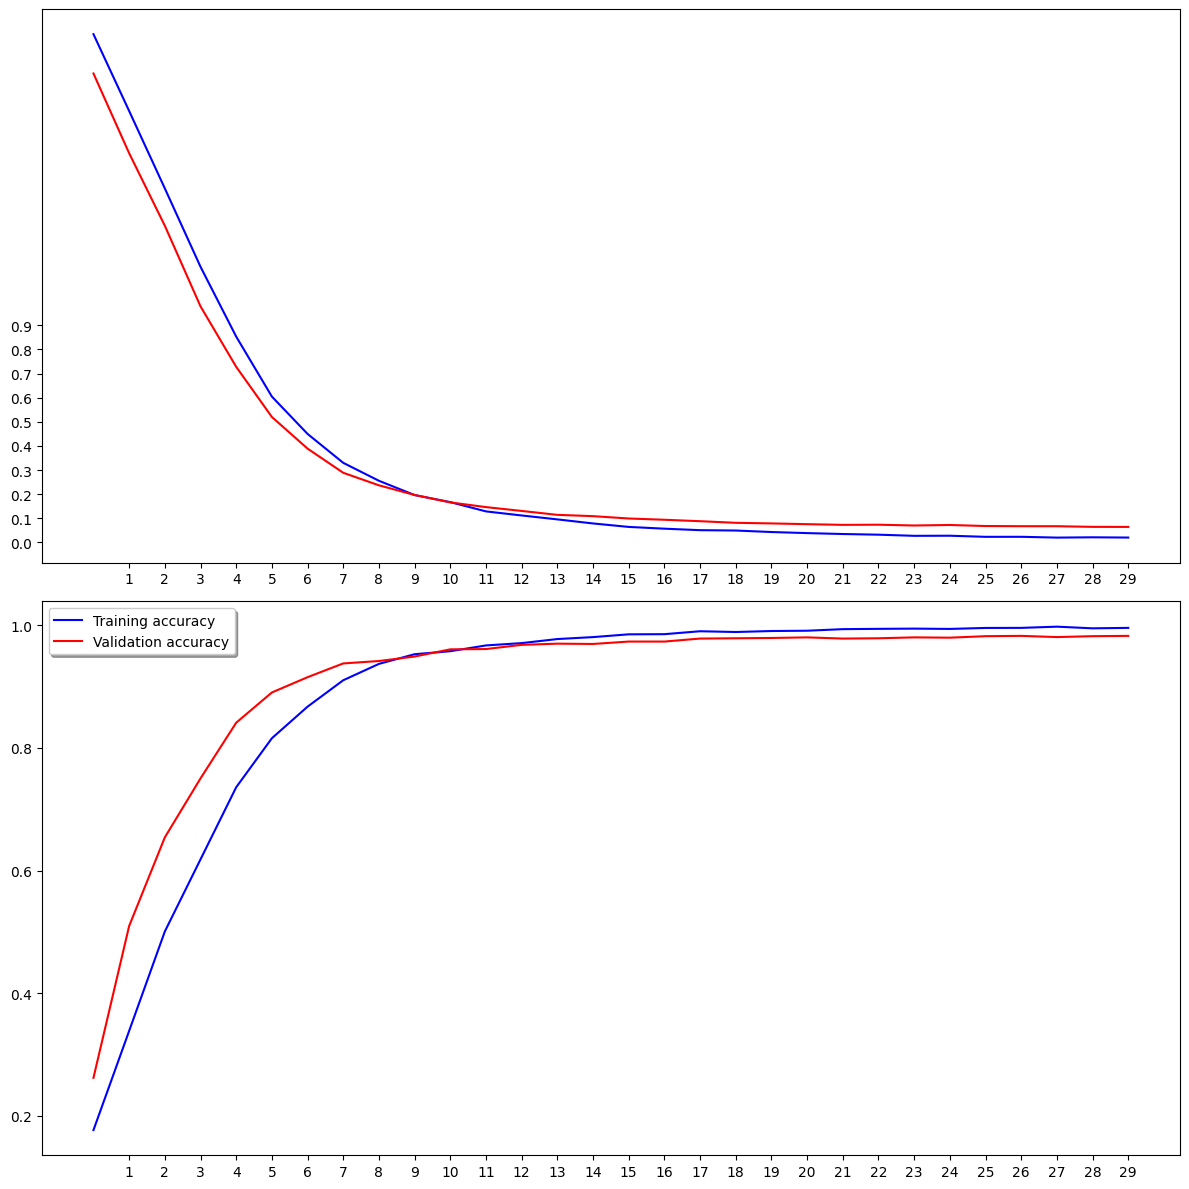

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history_inc.history['loss'], color='b', label="Training loss")
ax1.plot(model_history_inc.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history_inc.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history_inc.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 30, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [34]:
top_models_inc.load_weights('drive/MyDrive/models/distracted-inception_dropout_best.hdf5')

In [ ]:
print(top_models_inc)

In [ ]:
# evaluate_data = datagen.flow_from_directory(UNSEEN_DATA,
#                                         target_size=(IMAGE_SIZE,IMAGE_SIZE),
#                                         batch_size=BATCH_SIZE,shuffle=False)

In [35]:
ypred = top_models_inc.predict(test_data)
print(ypred)
evaluate_list = test_data.classes.tolist()
ypred_class = np.argmax(ypred,axis=1)
print(ypred_class)
ytest = evaluate_list
print(ytest)

54/54 [==============================] - 79s 1s/step
[[9.61379349e-01 2.27573118e-03 4.95999260e-03 ... 5.33658429e-04
  3.39314737e-03 1.54667087e-02]
 [9.98914719e-01 1.93819986e-04 3.04145040e-04 ... 1.06806037e-05
  8.38080377e-05 1.75708992e-04]
 [9.96447563e-01 2.85514630e-04 2.39978777e-03 ... 4.14372953e-05
  1.16642696e-04 1.98181777e-04]
 ...
 [4.19013340e-05 1.36981529e-04 2.01753919e-05 ... 4.74189401e-05
  4.06292493e-05 9.99676466e-01]
 [5.65983937e-04 1.18189876e-03 4.39502182e-04 ... 2.88784364e-03
  8.56062543e-05 9.94472563e-01]
 [7.39132287e-04 4.62289341e-03 1.70292900e-04 ... 5.98288514e-03
  3.64307896e-04 9.87689376e-01]]
[0 0 0 ... 7 7 7]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [36]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.983890
Precision: 0.983916
Recall: 0.983890
F1 score: 0.983858


In [37]:
top_models_inc.evaluate(test_data)

54/54 [==============================] - 81s 1s/step - loss: 0.0550 - accuracy: 0.9839


[0.05502665415406227, 0.9838898777961731]

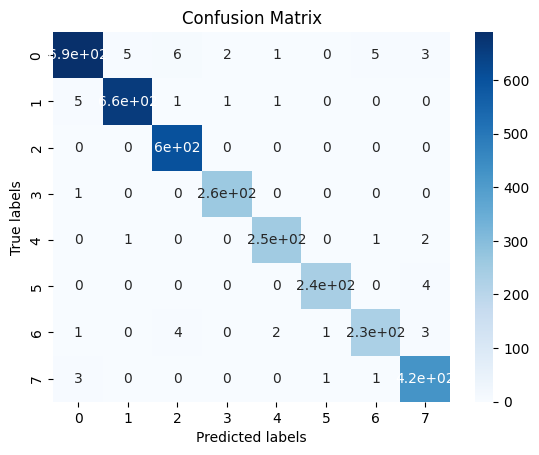

In [38]:
cm = confusion_matrix(ytest, ypred_class)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [39]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels,predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [40]:
class_names = list()
for name,idx in valid_data.class_indices.items():
    class_names.append(name)
print(class_names)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']


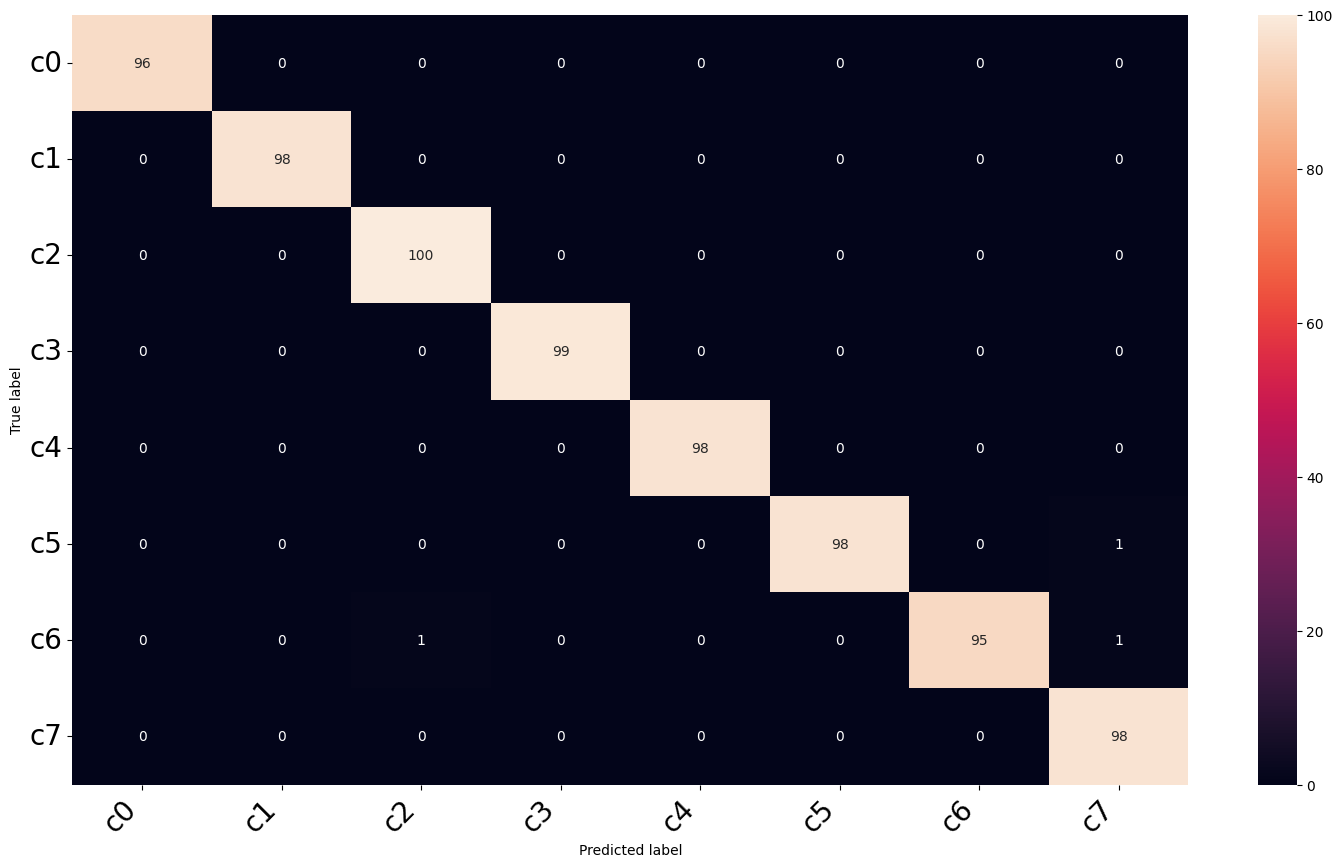

In [41]:
print_heatmap(ytest,ypred,class_names)

####Show a few example from unseen data folder

1/1 [==============================] - 0s 30ms/step


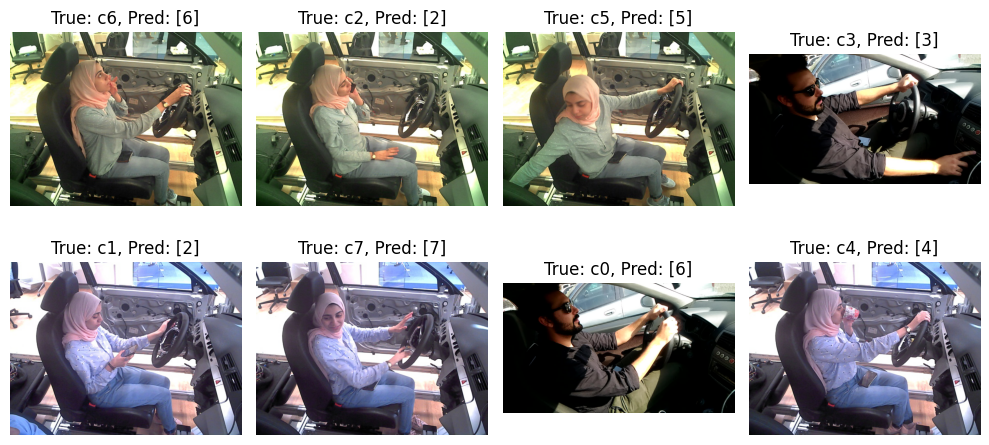

In [89]:
imgs = []
y_preds = []
y_trues = []
for cls in os.listdir(UNSEEN_PATH):
  if cls != '.DS_Store':
    cls_path = os.path.join(UNSEEN_PATH, cls)
    img_name = os.listdir(cls_path)[52]
    img_path = os.path.join(cls_path, img_name)
    img = Image.open(img_path)
    imgs.append(img)
    img_resize = img.resize((224, 224))
    img_array = np.array(img_resize)
    img_array = np.expand_dims(img_array, axis=0)
    input_data = preprocess_input(img_array)
    y_pred = top_models_inc.predict(input_data)
    y_pred = np.argmax(y_pred, axis=1)
    y_preds.append(y_pred)
    y_trues.append(cls)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    # Plot the image
    img = imgs[i]
    ax.imshow(img)
    ax.axis('off')
    
    # Get the true and predicted labels
    true_label = y_trues[i]
    pred_label = y_preds[i]
    
    # Set the title of the plot with the true and predicted labels
    ax.set_title(f'True: {true_label}, Pred: {pred_label}')
    
    # Break out of the loop after 12 images have been plotted
    if i == 7:
        break

plt.tight_layout()
plt.show()